<a href="https://colab.research.google.com/github/tarangar22/ece-gy-7123/blob/main/gru.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
from google.colab import drive
import torch

drive.mount('mount/')
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")
print(device)

#!git clone https://github.com/soerenab/AudioMNIST

Drive already mounted at mount/; to attempt to forcibly remount, call drive.mount("mount/", force_remount=True).
cuda:0


In [28]:
import os
import numpy as np
import csv

data_path = 'mount/MyDrive/data/'
label_path = 'mount/MyDrive/labels.csv'

data = [f for f in os.listdir(data_path)]
labels = []
for i in data:
  labels.append(i[0])

with open(label_path, 'w') as f:
  write = csv.writer(f)
  write.writerows(np.vstack((data,labels)).T)
f.close()

In [29]:
from torch.utils.data import Dataset
import pandas as pd
from os import path
import torchaudio as ta

n_fft = 2048
win_length = None
hop_length = 512
n_mels = 512
n_mfcc = 13

mfcc_transform = ta.transforms.MFCC(
    sample_rate=22050,
    n_mfcc=n_mfcc,
    melkwargs={
      'n_fft': n_fft,
      'n_mels': n_mels,
      'hop_length': hop_length,
      'mel_scale': 'htk',
    })

class AudioMNIST(Dataset):
    def __init__(self, labels, data, transform=None, target_transform=None):
        self.labels = pd.read_csv(labels, header=None)
        self.data = data
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        path = os.path.join(self.data, self.labels.iloc[idx, 0])
        wave, sr = ta.load(path)
        label = self.labels.iloc[idx, 1]
        if self.transform:
            wave = torch.cat((wave.flatten(), torch.zeros(48000-len(wave.T))))
            wave = ta.transforms.Resample(48000, 22050)(wave)
            wave = mfcc_transform(wave)
            #wave = ta.transforms.SlidingWindowCmn()(wave)
        if self.target_transform:
            label = self.target_transform(label)
        return wave.T, label

audiomnist = AudioMNIST(label_path, data_path, True)

/usr/local/lib/python3.7/dist-packages/torchaudio/functional/functional.py:595: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (512) may be set too high. Or, the value for `n_freqs` (1025) may be set too low.
  "At least one mel filterbank has all zero values. "


In [30]:
import torch
import random
import torch.nn.functional as F

batch_size = 256

train, test = torch.utils.data.random_split(audiomnist, [10240, 19760], generator=torch.Generator().manual_seed(42))
traindataloader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
testdataloader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=True)

torch.Size([44, 13])
3


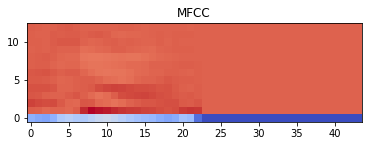

In [31]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
import librosa
import librosa.display


for i, data in enumerate(traindataloader):
    fig, ax = plt.subplots()
    print(data[0][0].size())
    mfcc_data= np.swapaxes(data[0][0].squeeze().numpy(), 0 ,1)
    cax = ax.imshow(mfcc_data, interpolation='nearest', cmap=cm.coolwarm, origin='lower')
    ax.set_title('MFCC')
    plt.show()
    print(data[1][0].numpy())
    break

def mfcc_extract(filename):
    y, sr  = librosa.load(filename, sr = 44100)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13, n_fft=int(0.02*sr),hop_length=int(0.01*sr))
    return mfcc

In [32]:
class EncoderRNN(torch.nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = torch.nn.Embedding(input_size, hidden_size)
        self.gru = torch.nn.GRU(input_size, hidden_size, batch_first=True, bidirectional=False)

    def forward(self, input, hidden):
        #input = self.embedding(input)
        output, hidden = self.gru(input, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, batch_size, self.hidden_size).to(device)

In [33]:
MAX_LENGTH = 44

class AttnDecoderRNN(torch.nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = torch.nn.Embedding(self.output_size, self.hidden_size)
        self.attn = torch.nn.Linear(self.hidden_size + 13, self.max_length)
        self.attn_combine = torch.nn.Linear(self.hidden_size + 13, self.hidden_size)
        self.dropout = torch.nn.Dropout(self.dropout_p)
        self.gru = torch.nn.GRU(self.hidden_size, self.hidden_size, batch_first=True, bidirectional=False)
        self.out = torch.nn.Linear(self.hidden_size, self.output_size)

    def forward(self, embedded, hidden, encoder_outputs):
        #embedded = self.dropout(input)
        attn_weights = F.softmax(
            self.attn(torch.cat((embedded, torch.reshape(hidden, (batch_size, 1, self.hidden_size))), -1)), dim=-1)
        attn_applied = torch.bmm(attn_weights, encoder_outputs)
        output = torch.cat((embedded, attn_applied), -1)
        output = self.attn_combine(output)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.out(output)
        output = F.sigmoid(output)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, batch_size, self.hidden_size).to(device)

In [34]:
hidden_size = 64
encoder1 = EncoderRNN(13, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, 13, dropout_p=0.1).to(device)

encoder_optimizer = torch.optim.Adam(encoder1.parameters(), lr=0.004, amsgrad=True)
decoder_optimizer = torch.optim.Adam(attn_decoder1.parameters(), lr=0.004, amsgrad=True)
criterion = torch.nn.KLDivLoss()

In [35]:
teacher_forcing_ratio = 0.5
def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    loss = 0
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    target_length = max_length
    encoder_outputs = torch.zeros(batch_size, max_length, encoder.hidden_size).to(device)

    encoder_outputs, encoder_hidden = encoder(
                        input_tensor, encoder_hidden)

    decoder_input = torch.zeros(batch_size, 1, 13).to(device)
    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
    if use_teacher_forcing:
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, 
                              target_tensor[:, di:di+1, :])
            decoder_input = target_tensor[:, di:di+1, :]

    else:
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_input = decoder_output
            loss += criterion(decoder_output, 
                              target_tensor[:, di:di+1, :])

    loss.backward()

    decoder_optimizer.step()
    encoder_optimizer.step()

    return loss.item() / target_length

In [36]:
plt.switch_backend('agg')
import matplotlib.ticker as ticker

def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:2748: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  "reduction: 'mean' divides the total loss by both the batch size and the support size."


epoch :  0 loss :  39.86581087979403
epoch :  1 loss :  39.08012473366476
epoch :  2 loss :  39.073931537974964
epoch :  3 loss :  39.07113585038619
epoch :  4 loss :  39.06939815174449
epoch :  5 loss :  39.06823883056641
epoch :  6 loss :  39.0674260226163
epoch :  7 loss :  39.06683363481002
epoch :  8 loss :  39.06638627485795
epoch :  9 loss :  39.06603872125798


<Figure size 432x288 with 0 Axes>

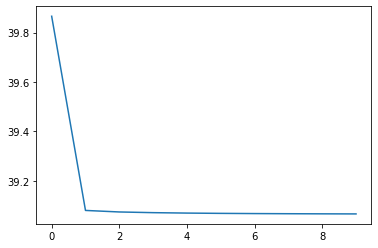

In [37]:
plot_losses = []

for iter in range(10):
    print_loss_total = 0
    plot_loss_total = 0

    for i, data in enumerate(traindataloader):
        wave = data[0]
        wave = wave.cuda()
        loss = train(wave, wave, encoder1, attn_decoder1, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

    plot_loss_avg = plot_loss_total/len(traindataloader)
    plot_losses.append(plot_loss_avg)

    print("epoch : ", iter, "loss : ", plot_loss_avg)

showPlot(plot_losses)